# <center>Bayesian metamodeling tutorial</center>
<center>Tanmoy Sanyal</center>
<center>Sali Lab, UCSF</center>

This tutorial is intended to provide a hands-on experience with constructing Bayesian metamodels from a combination of sub-models. In a nutshell, *meta-modeling* is a bayesian divide-and-conquer modeling strategy that is designed to integrate input models of different representation into an overarching model that can be (in principle) used to investigate all relevant variables of all sub-models simultaneously. Such a framework is crucial to modeling complicated systems with several degrees of freedom such as cellular processes in biology. Further details may be found in the associated [paper](https://www.pnas.org/).

For computational simplicity, all models used in this tutorial are toy systems, and as such one should not attach biological significance to the results obtained by coupling such toy models to each other. It is instructive however, to note the modular design of the meta-modeling framework and how such a design enables information flow between seemingly disparate sub-models.

The tutorial is divided into three sections with increasing complexity. To keep the material general enough, certain implementation details have been intentionally abstracted out, and can be found on the [github repository](https://github.com/) that hosts the tutorial.

For those of you who are unfamiliar with Jupyter notebooks:

**This is an interactive notebook**
It consists of separate blocks called *cells*. Some of this cells contain Python code that can be run directly. To run a code-cell, use the run button in the toolbar:
<div><img src=./tutorial_figs/run_button.png width=500></div>
<br><br><br>

To maximize readability, all code is hidden by default. Use the visbility button
<div><img src=./tutorial_figs/toggle_button.png width=80></div> placed at the top right of the toolbar to toggle code visibility on and off.

# 1. Background

## Bayesian inference
We begin with a brief and general overview of Bayesian inference.

1. In Bayesian modeling of a system (e.g., a cellular process), we typically want to base our model ($M$) on given experimental data ($D$) as well as our prior information about the system ($\theta$). Here, $M$ represents the degrees of freedom appropriate to the model, such as particle coordinates for a molecular simulation model or chemical concentrations for a pharmacokinetic model. $\theta$ encodes parameters which can either convey our beliefs about the system such as $M$ belonging to a gaussian distribution, and/or impose hard constraints on the system, such as the dimension of the simulation box being a particular (constant) value in a molecular simulation.


2. A useful way to choose a model that reflects the data and our prior knowledge is to pick it from a family of alternative models and define a quantitative score that distinguishes good models from worse ones. Intuitively, good models are ones that make more or less sense in light of the (noisy and often ambiguous and incomplete) data $D$ and our prior knowledge $\theta$.


3. A practical way to score good or bad models is to assign a *posterior probability* for each model given the data and our prior knowledge about the system $P(M \mid D, \theta)$. A helpful analogy to think about posterior probabilities is to consider the difference between: (a) the probability of finding hidden treasure buried near your house given no other information, vs (b) the same probability given that a metal detector started ringing at a spot just outside where you live. (a) and (b) provide different amounts of information and in this case, intuitively (b) is more informative than (a). But how do we estimate posterior probabilities?


4. The Bayesian method seeks to use the *likelihood* of the data given the model and priors, i.e. $P(D \mid M, \theta)$ to answer the opposite question, i.e $P(M \mid D, \theta)$. In some situations the advantage of this inverse approach is apparent. For instance, it is easier to compute the probability of a (simulated) cryo-EM map given all the degrees of freedom of a cell model, than calculating the probability of the latter, given experimental cryo-EM data.

The last step can be achieved through [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) which states that:

$$P(M \mid D, \theta) \propto P(D \mid M, \theta) \; P(M, \theta)$$

where, $P(M, \theta)$ conveys the *prior* distribution of $M$ given other information $\theta$ and is typically factorized as $P(M \mid \theta)\; P(\theta)$ ,i.e. the product of the conditional probability of $M$ given $\theta$ and the probability of observing the component/(s) of $\theta$ themselves.

## Meta-modeling 
The ability to describe $P(M \mid D, \theta)$ given different (and typically independently determined) sets of data $D$ is formally described as [Integrative Modeling](https://integrativemodeling.org/) in context of computational structural biology. While such an approach works well for modeling protein complexes, a model of the entire cell is arguably much more complex with many many more degrees of freedom, prompting researchers to create separate models that may be very different in representation and scale from each other, to focus on particular structural and functional aspects of the cell. E.g., a pharamacokinetic model usually investigates the temporal variation of species concentrations and contains no spatial information, whereas a molecular dynamics simulation is practically limited to tens of nanometers and millseconds at best. While both these models considered together provide more information than any one of them alone, the difference in representation makes it difficult to share information between them. Metamodeling facilitates this information exchange in a rigorous Bayesian manner, by translating different input models to a common underlying statistical representation.

Thus (unlike integrative modeling) in metamodeling, we go beyond coupling all available data to a single model and start to couple different input models that may include their own datasets used for their respective parameterization. Interestingly, metamodeling does not require all input models to have available data.

## Probabilistic Graphical Models (PGMs)
We use [*probabilistic graphical models*](https://mitpress.mit.edu/books/probabilistic-graphical-models) to implement metamodeling. PGMs are graphical representations of complex joint probability distributions that enable efficient data storage and (by construction) provide systematic protocols to understand the conditional inter-dependencies between different parts of the model (or for that matter different models, as we shall see in section 3). We note that statistical coupling of different input models may be achieved through other probabilistic machine learing techniques like [variational autoencoders (VAEs)](https://arxiv.org/pdf/1906.02691.pdf) and [generative adversarial networks (GANs)](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) but for the purposes of this tutorial, we shall limit ourselves to a PGM based approach.

The most general PGM for a model $M$ with data $D$ and prior information $\theta$ can be drawn as
<br></br>
<br></br>
<div><img src="tutorial_figs/bayes_theorem_pgm.png" width=250></div>

In a PGM like this, the nodes (circles) represent the (random) variables, while edges capture the statistical dependencies between nodes by denoting *conditional probability distributions* (CPDs), i.e., the probability of a node given the values of its parent nodes. In a nustshell, this PGM can be interpreted by starting from the root (nodes without parents, in this case $\theta$) and multipying CPDs as edges are traversed in the direction of their arrows. The PGM provides a visually clear way to apply Bayes' theorem: multiplying the edge CPDs $P(D \mid M)$, $P(M \mid \theta)$ and $P(\theta)$, leads back to the RHS of the equation in section 1.

Note that in this representation, $P(M \mid \theta)$ is actually a probabilistic interpretation of the equations that describe how the degrees of freedom can be obtained from other information. Thus, for a molecular dynamics simulation these equations could be (numerically discretized) Newton's laws of motion, while for pharmacokinetic models, they could be ordinary differential equations (ODEs) describing species concentrations as functions of time.

<strong>Probabilistic programming languages</strong> (PPLs) are computational implementations of PGMs built in well known programming languages that enable fast algberaic operations on distributions. In this tutorial, we'll use a well-known PPL called [PyMC3](https://docs.pymc.io).

# 2. Metamodeling in practice: How to couple different PGMs? 

This section demonstrates how to couple two toy models of a drug dosing protocol. First we load some Python libraries that will be useful throughout the tutorial.

In [3]:
# import python libraries that will be required repeatedly

# general python stuff
import os
import sys
import numpy as np
import copy
import matplotlib.pyplot as plt

# the PyMC3 package
import pymc3 as pm

sys.path.append("..")
from mm.core import jit # custom-wrapper for model compilation
from mm.utils import set_start # custom helper function to set starting point for timeseries models

# functions written to make my life easier while writing this tutorial
import tutorial_utils as tu

# number of samples to draw for plotting distributions
ns = 100

Suppose we are interested in the studying the effect of a new drug on cancer cell growth. To make things simpler, we focus on one particular tumor cell which was treated with the drug and exhibited show reduction in volume over a period of time. Load the daily cell volume measurement (done over a period of 29 days) (kept in ```tutorial_datasets/tumor_vol.dat```)

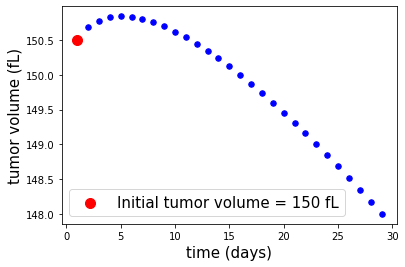

In [4]:
# extract data
data = np.loadtxt("./tutorial_datasets/tumor_vol.dat")
time_data = data[:,0]
tumor_volume_data = data[:,1]

# target values of variables used in this section
k1_target = 1.0
k2_target = 2.0
n_target = 0.75

# get starting cell volume 
initial_tumor_volume = tumor_volume_data[0]

# plot
plt.scatter(time_data, tumor_volume_data
, s=30, c="blue")
plt.scatter(time_data[0], initial_tumor_volume, s=100, c="red", label="Initial tumor volume = 150 fL")
plt.xlabel("time (days)", fontsize=15)
plt.ylabel("tumor volume (fL)", fontsize=15)
plt.legend(prop={"size": 15})
plt.show();

This is the *data* that we referred to as $D$, in section 1. Here, we'll refer to it as $V^{obs}$

## A. The treatment Model

As the simplest possible model of the treatment, we assume that the tumor volume reduces linearly everyday according to $$V(t) = V_0 - k_1t$$ where $V_0$ is the starting volume of the tumor (~150 fL) and $k_1$ is the steady reduction rate. $k_1$ thus is a metric of the efficiency of this treatment. To relate back to the notation introduced in section 1, the equation above represents a *family of models* with a single degree of freedom ($M$) $k_1$. We want to choose values of $k_1$ that maximize the posterior probability of the model given the volume profile data i.e., $P(k_1 \mid V^{obs})$.

Assume that (based on our prior experiences with tumor cells or from literature surveys) $k_1$ can be approximated as a Gaussian or Normal distribution with mean 0.8 fL/day and std. deviation 1.0 fL/day.

Let us build a PGM for this model and present it with the tumor volume data as evidence.

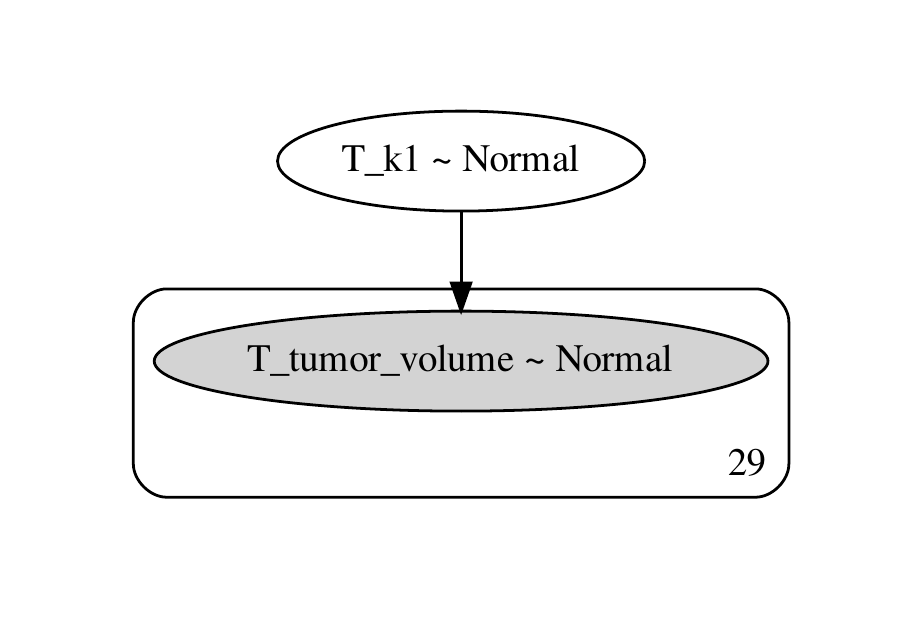

In [6]:
@jit
def TreatmentModel(name="T", inputs={}, evidence={}, start={}):
    t = inputs["t"]
    V0 = inputs["V0"]
    k1 = pm.Normal("k1", mu=0.8, sigma=1.0)
    V = pm.Normal("tumor_volume", mu=V0-k1*t, sigma=1.0, shape=len(t))
    
m1 = TreatmentModel(name="T",
                    inputs={"t": time_data, "V0": initial_tumor_volume},
                    evidence={"T_tumor_volume": tumor_volume_data},
                    start={})
tu.visualize_model(m1)

What does the above graphical model represent?

1. The node ```T_k1``` is the reduction rate $k_1$ according to the treatment model. The node ```T_tumor_volume``` is the volume of the tumor over time $V(t)$. The arrow expresses the dependency of the tumor volume profile on the value of $k_1$. Thus $k_1$ is a degree of freedom of our model, and we would like to choose a value for $k_1$ that best explaiins our data.


2. The notation ```T_k1 ~ Normal``` means that the variable $k_1$ is distributed according to a Normal distribution (remember, that our prior knowledge says that $k_1$ belongs to a Normal distribution with mean 0.8 and std. dev 1.0, i.e. $k_1 \sim \mathcal{N}(0.8, 1.0)$. The parameters 0.8 and 1.0 that parameterize the prior distribution on $k_1$ serve as the parameters $\theta$ in section 1. In this case, their probability distribution ($P(\theta)$) is unimportant, since they are constants.

The rest of the terms below are necessary only in the context of the Python code, and may be skipped without loss of continuity.

1. <strong>MBF</strong>: PGMs are defined using Python functions called the "model-builder-function" or MBF. The model (PGM) can have any name, here we arbitrarily chose the name "T".


2. <strong>```inputs```</strong>: This specifies variables that are supplied to the model to be used as is. In this case, it was the array of time points and initial tumor volume. Inputs can be useful for coupling models to each other.


3. <strong>```evidence```</strong>: This represents the data ($V^{obs}$) used to train the model. Evidence nodes are shaded in the graph. (The number 29 in the bottom left corner of the rectangle represents the number of data points used i.e. 29 measurements for 29 days).


4. <strong>```start```</strong> : This designates the starting points (```t=0``` values) of variables that are time varying and dependent on past values (i.e. when $x(t)$ depends on $x(t-1)$, etc.). For this simple model, none of the variables have dependence on past values, so this argument remains empty.

Now, we train the model using PyMC3's inbuilt Bayesian inference implementation.


Training treatment model...


Average Loss = 35.324: 100%|██████████| 50000/50000 [00:14<00:00, 3552.49it/s]
Finished [100%]: Average Loss = 35.326


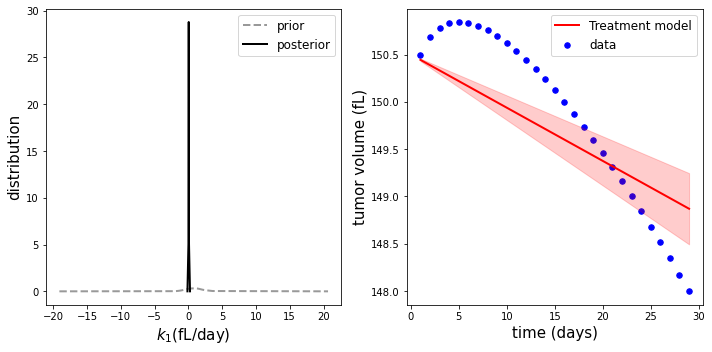

In [7]:
# collect prior samples
k1_pri_samples = tu.get_prior_samples(m1, "T_k1", samples=ns)

# train the model
print("\nTraining treatment model...")
_, trace = tu.sample_posterior(m1, tune=50000, samples=ns)

# collect posterior samples
k1_post_samples = trace["T_k1"]
tumor_volume_post_samples = np.array([initial_tumor_volume - k1_post_samples[i]*time_data
                                      for i in range(ns)])

# convert all samples to histograms
k1_pri = tu.get_distribution(k1_pri_samples, vartype="static", smooth=True)
k1_post = tu.get_distribution(k1_post_samples, vartype="static", smooth=True)
tumor_volume_post, tumor_volume_post_err = tu.get_distribution(tumor_volume_post_samples, vartype="dynamic")

# plot
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel(r"$k_1 \mathrm{ (fL/day)}$", fontsize=15)
ax1.set_ylabel("distribution", fontsize=15)
ax1.plot(k1_pri[0], k1_pri[1], "k-", lw=2, ls="--", alpha=0.4, label="prior")
ax1.plot(k1_post[0], k1_post[1], "k-", lw=2, label="posterior")

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel("time (days)", fontsize=15)
ax2.set_ylabel("tumor volume (fL)", fontsize=15)
ax2.scatter(time_data, tumor_volume_data, s=30, c="blue", label="data")
ax2.plot(time_data, tumor_volume_post, "r-", lw=2, label="Treatment model")
ax2.fill_between(time_data,
                 tumor_volume_post - tumor_volume_post_err, 
                 tumor_volume_post + tumor_volume_post_err,
                 color="r", alpha=0.2)

ax1.legend(prop={"size": 12})
ax2.legend(prop={"size": 12})
fig.tight_layout()
plt.show();

Clearly the treatment model does a bad job. The influence of training data $V^{obs}$ does end up adjusting the posterior probability of $k_1$ and narrowing the spread (compared to the prior Normal distribution), but this estimate predicts a sharply linear volume reduction and does not explain why the tumor was still growing till day 6 or so.

## B. The growth Model

At this point, suppose a colleague offers a solution in the form of another possible dose model that might explain the data. They insist that the internal growth dynamics of the tumor actually overwhelm the therapy and these dynamics are complex enough to explain both the initial increase and subsequent reduction in volume. They even provide a power-law model for the growth $$V(t)=V_0 + k_2t^n$$ where $k_2$ (fL/day) is the steady growth rate and the exponent $n$ is dimensionless. The task now is to choose values of both $k_2$ and $n$ that best explains the data. 

Although we get ready to try out the co-worker's solution, we still encode our belief about a possibly linear therapy profile by imposing that $n$ be distributed according to a Normal distribution with mean 0 (and std. dev 0.1). We put another prior on $k_2$ requiring it to be normally distributed with mean 1.5 fL/day and std. dev. 0.1 fL/day.

*Note: There is actually another prior implicit in the construction of this model, namely that the treatment has no action. This is obviously contrived for the purpose of presentation in this tutorial.*

We construct the PGM for this model (labelled "G"):

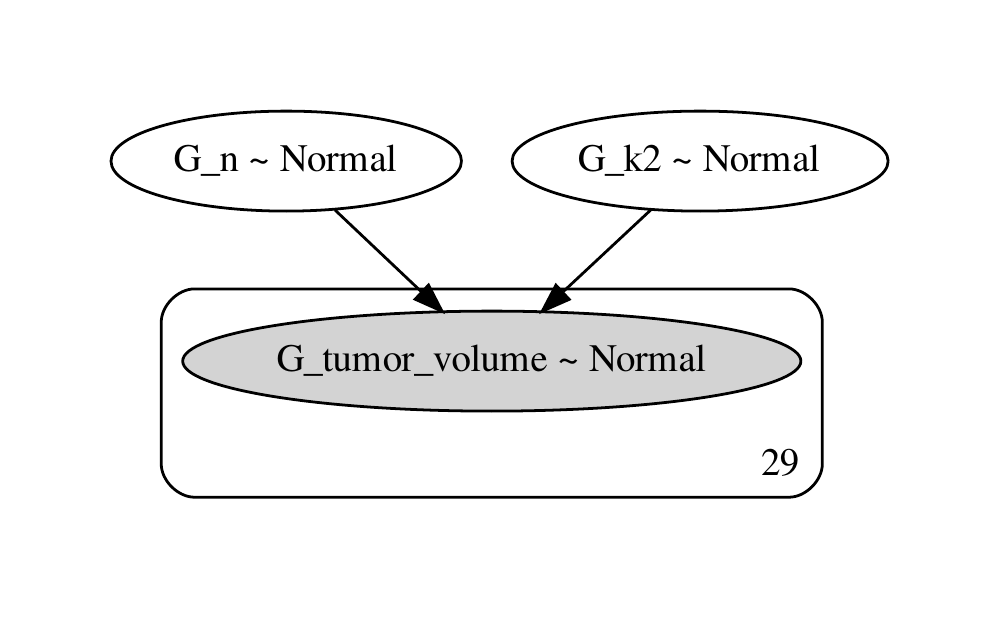

In [10]:
@jit
def GrowthModel(name="G", inputs={}, evidence={}, start={}):
    t = inputs["t"]
    V0 = inputs["V0"]
    k2 = pm.Normal("k2", mu=1.5, sigma=0.1)
    n = pm.Normal("n", mu=0.0, sigma=0.1)
    V = pm.Normal("tumor_volume", mu=V0+k2*t**n, sigma=0.1, shape=len(t))

m2 = GrowthModel(name="G",
                 inputs={"t":time_data, "V0": initial_tumor_volume},
                 evidence={"G_tumor_volume": tumor_volume_data},
                 start={})
tu.visualize_model(m2, h=600, w=600)

Like before:
1. The nodes ```G_k2``` and ```G_n``` are the increase rate $k_2$ and the exponent $n$. The node ```G_tumor_volume``` is the volume of the tumor over time $V(t)$. The arrows show that the tumor volume over time depends on the values of $k_2$ and $n$, which form the degrees of freedom of this model.


2. The notations ```G_k2 ~ Normal``` and ```G_n ~ Normal``` means that the variables $k_2$ and $n$ are distributed according to Normal distributions (remember, that our prior knowledge says that $k_2 \sim \mathcal{N}(1.5, 0.1)$ and $n \sim \mathcal{N}(0, 0.1)$.

We train against the given daily tumor volume data:


Training growth model...


Average Loss = 1,891.6: 100%|██████████| 50000/50000 [00:13<00:00, 3754.53it/s]  
Finished [100%]: Average Loss = 1,891.6


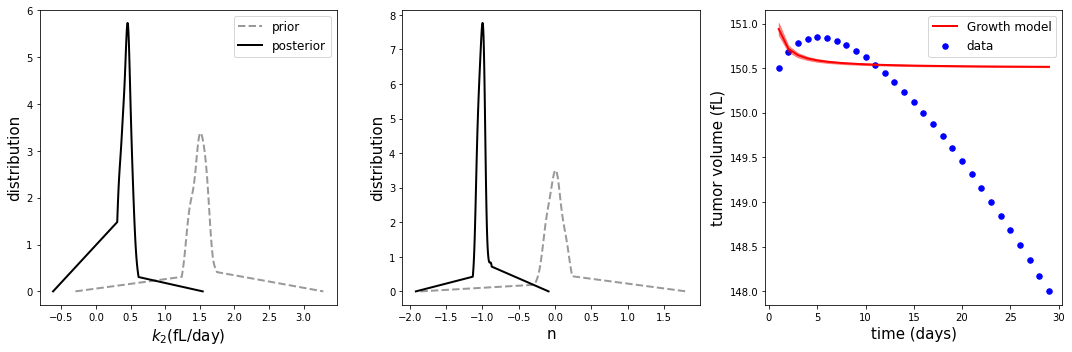

In [9]:
# collect prior samples
k2_pri_samples = tu.get_prior_samples(m2, "G_k2", samples=ns)
n_pri_samples = tu.get_prior_samples(m2, "G_n", samples=ns)

# train the model
print("\nTraining growth model...")
_, trace = tu.sample_posterior(m2, tune=50000, samples=ns)

# collect posterior samples
n_post_samples = trace["G_n"]
k2_post_samples = trace["G_k2"]
tumor_volume_post_samples = np.array([initial_tumor_volume + k2_post_samples[i]*time_data**n_post_samples[i]
                                      for i in range(ns)])

# convert all samples to histograms
k2_pri = tu.get_distribution(k2_pri_samples, vartype="static", smooth=True)
n_pri = tu.get_distribution(n_pri_samples, vartype="static", smooth=True)
k2_post = tu.get_distribution(k2_post_samples, vartype="static", smooth=True)
n_post = tu.get_distribution(n_post_samples, vartype="static", smooth=True)
tumor_volume_post, tumor_volume_post_err = tu.get_distribution(tumor_volume_post_samples, vartype="dynamic")

# plot
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
ax1.set_xlabel("$k_2 \mathrm{ (fL/day)}$", fontsize=15)
ax1.set_ylabel("distribution", fontsize=15)
ax1.plot(k2_pri[0], k2_pri[1], "k-", lw=2, ls="--", alpha=0.4, label="prior")
ax1.plot(k2_post[0], k2_post[1], "k-", lw=2, label="posterior")

ax2 = fig.add_subplot(1,3,2)
ax2.set_xlabel("n", fontsize=15)
ax2.set_ylabel("distribution", fontsize=15)
ax2.plot(n_pri[0], n_pri[1], "k-", lw=2, ls="--", alpha=0.4)
ax2.plot(n_post[0], n_post[1], "k-", lw=2)

ax3 = fig.add_subplot(1,3,3)
ax3.set_xlabel("time (days)", fontsize=15)
ax3.set_ylabel("tumor volume (fL)", fontsize=15)
ax3.scatter(time_data, tumor_volume_data, s=30, c="blue", label="data")
ax3.plot(time_data, tumor_volume_post, "r-", lw=2, label="Growth model")
ax3.fill_between(time_data, 
                 tumor_volume_post - tumor_volume_post_err,
                 tumor_volume_post + tumor_volume_post_err, 
                 color="r", alpha=0.4)

ax1.legend(prop={"size": 12})
ax3.legend(prop={"size": 12})
fig.tight_layout()
plt.show();

While the treatment model predicted at least a decreasing profile, the growth model settles down to more or less a constant tumor volume of ~150.75 fL/day after day 3 or so. We observe that the posterior estimate of the exponent $n$ (middle panel) has a mean of ~ -1.0 which suggests a rectangular hyperbola profile for $V(t)$ (to see why: plug back $n=-1$ in the model equation), very similar to what is observed.

## C. The metamodel

Instead of throwing away both the treatment and the growth models, we combine these to form a metamodel that is informed by both us and our coworker's beliefs:

We, Construct the PGM for the metamodel (call it "MM"):

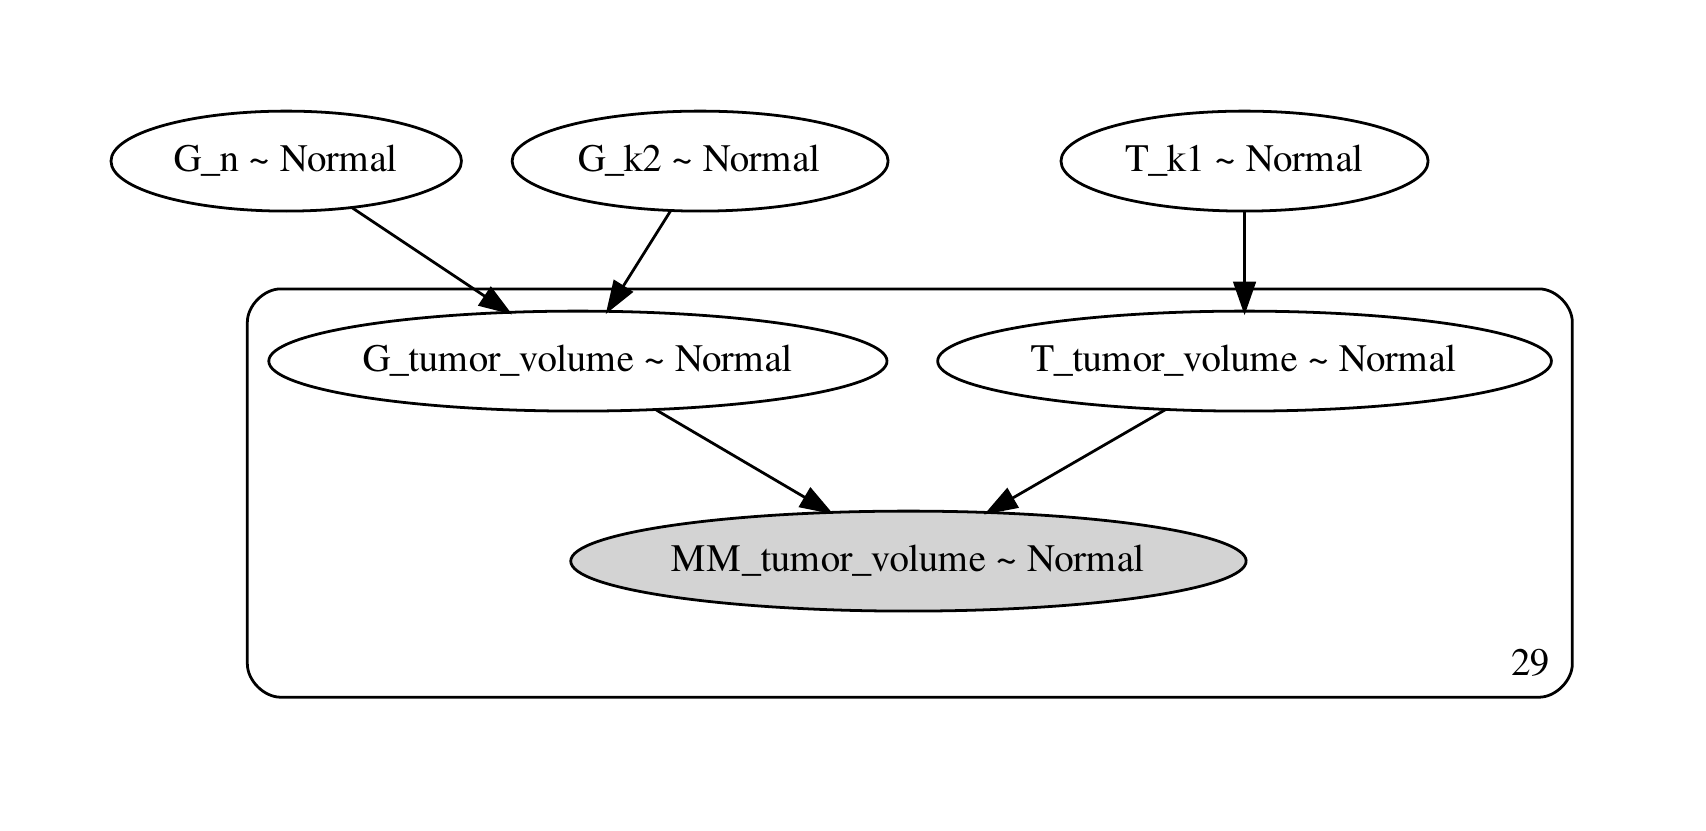

In [11]:
@jit
def MetaModel(name="MM", inputs={}, evidence={}, start={}):
    t = inputs["t"]
    V0 = inputs["V0"]
    
    # call the MBF for the treatment model
    T = TreatmentModel(name="T", inputs=inputs, evidence=evidence, start=start)
    
    # call the MBF for the growth model 
    G = GrowthModel(name="G", inputs=inputs, evidence=evidence, start=start)
    
    # combine (average) the tumor volume predictions from both models
    tumor_volume = pm.Normal("tumor_volume", mu=(T.tumor_volume + G.tumor_volume)/2., sigma=0.1, shape=len(t))
    
m3 = MetaModel(name="MM",
               inputs={"t":time_data, "V0": initial_tumor_volume},
               evidence={"MM_tumor_volume": tumor_volume_data},
               start={})
tu.visualize_model(m3, h=800, w=800)

The treatment and growth models with their variables($k_1$ and, ($k_2, n$), respectively) and edges (as defined before in their respective PGMs) still exist, but the tumor volume nodes from each of them (```T_tumor_volume``` and ```G_tumor_volume```) have now been *coupled* into a single metamodel node ```MM_tumor_volume```. This combination could be any function in principle, here we go with the simplest possible expression, an arithmetic average:

$$V_\mathrm{metamodel}(t) = \frac{V_\mathrm{treatment \; model}(t) + V_\mathrm{growth\; model}(t)}{2}$$


The new edges that connect the nodes from either input model ```T_tumor_volume``` and ```G_tumor_volume``` to the metamodel node ```MM_v``` are called *active trails*. Active trails theoretically guarantee flow of information between the two models; e.g., information can now flow from the ```G_n``` and ```G_k2``` nodes to the ```T_k1``` node and vice versa. All edges can't be active trails and there exist certain well established rules of designing active trails. We shall not pursue further details here, but please reach out if you have questions.

Let us train this model with the same data as before and see how it peforms:


Training meta-model...


Average Loss = 35.081: 100%|██████████| 50000/50000 [00:19<00:00, 2573.14it/s]   
Finished [100%]: Average Loss = 35.059



Avg. uncertainty (std. dev / mean) of tumor volume prediction = 0.08 %


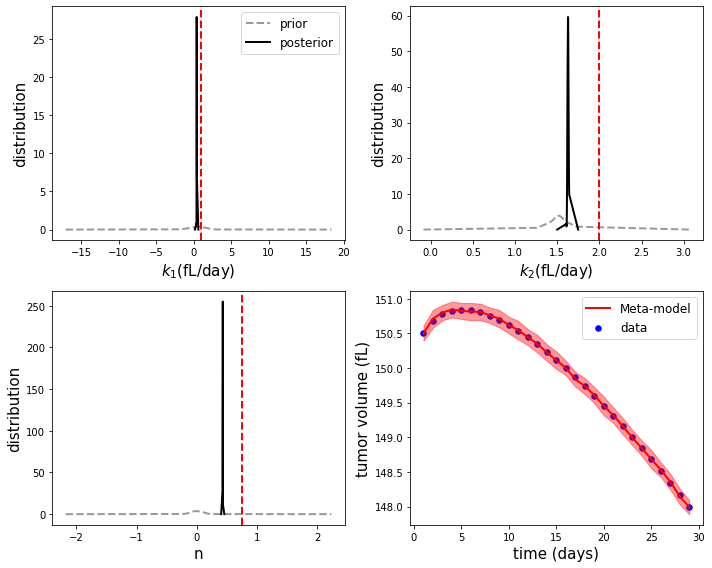

In [12]:
# collect prior samples
k1_pri_samples = tu.get_prior_samples(m3, "T_k1", samples=ns)
k2_pri_samples = tu.get_prior_samples(m3, "G_k2", samples=ns)
n_pri_samples = tu.get_prior_samples(m3, "G_n", samples=ns)

# train the model
print("\nTraining meta-model...")
_, trace = tu.sample_posterior(m3, tune=50000, samples=ns)

# collect posterior samples
k1_post_samples = trace["T_k1"]
k2_post_samples = trace["G_k2"]
n_post_samples = trace["G_n"]
tumor_volume_post_samples = 0.5*(trace["G_tumor_volume"] + trace["T_tumor_volume"])

# convert all samples to distributions 
k1_pri = tu.get_distribution(k1_pri_samples, vartype="static", smooth=True)
k2_pri = tu.get_distribution(k2_pri_samples, vartype="static", smooth=True)
n_pri = tu.get_distribution(n_pri_samples, vartype="static", smooth=True)
k1_post = tu.get_distribution(k1_post_samples, vartype="static", smooth=True)
k2_post = tu.get_distribution(k2_post_samples, vartype="static", smooth=True)
n_post = tu.get_distribution(n_post_samples, vartype="static", smooth=True)
tumor_volume_post, tumor_volume_post_err = tu.get_distribution(tumor_volume_post_samples, vartype="dynamic")

# display the average uncertainty of tumor volume prediction
stderr = 100. * np.mean(tumor_volume_post_err/tumor_volume_post)
print("\nAvg. uncertainty (std. dev / mean) of tumor volume prediction = %2.2f %%" % stderr)

# plot
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(2,2,1)
ax1.set_xlabel("$k_1 \mathrm{ (fL/day)}$", fontsize=15)
ax1.set_ylabel("distribution", fontsize=15)
ax1.plot(k1_pri[0], k1_pri[1], "k-", lw=2, ls="--", alpha=0.4, label="prior")
ax1.plot(k1_post[0], k1_post[1], "k-", lw=2, label="posterior")
ax1.axvline(k1_target, color="r", ls="--", lw=2)
ax2 = fig.add_subplot(2,2,2)
ax2.set_xlabel("$k_2 \mathrm{ (fL/day)}$", fontsize=15)
ax2.set_ylabel("distribution", fontsize=15)
ax2.plot(k2_pri[0], k2_pri[1], "k-", lw=2, ls="--", alpha=0.4)
ax2.plot(k2_post[0], k2_post[1], "k-", lw=2)
ax2.axvline(k2_target, color="r", ls="--", lw=2)

ax3 = fig.add_subplot(2,2,3)
ax3.set_xlabel("n", fontsize=15)
ax3.set_ylabel("distribution", fontsize=15)
ax3.plot(n_pri[0], n_pri[1], "k-", lw=2, ls="--", alpha=0.4)
ax3.plot(n_post[0], n_post[1], "k-", lw=2)
ax3.axvline(n_target, color="r", ls="--", lw=2)

ax4 = fig.add_subplot(2,2,4)
ax4.set_xlabel("time (days)", fontsize=15)
ax4.set_ylabel("tumor volume (fL)", fontsize=15)
ax4.scatter(time_data, tumor_volume_data, s=30, c="blue", label="data")
ax4.plot(time_data, tumor_volume_post, "r-", lw=2, label="Meta-model")
ax4.fill_between(time_data,
                 tumor_volume_post - tumor_volume_post_err,
                 tumor_volume_post + tumor_volume_post_err,
                 color="r", alpha=0.4)

ax1.legend(prop={"size": 12})
ax4.legend(prop={"size": 12})
fig.tight_layout()
plt.show();

Voila! We finally have estimates of $k_1$, $k_2$ and $n$ that can satisfactorily explain the initial growth and subsequent decay of the tumor volume data. The target values of $k_1$, $k_2$ and $n$ that were used to generate the synthetic values of the tumor volume profile $V^{obs}$  are shown in red dotted lines, and although we didn't recapture their exact values, the daily volume estimates we got are sufficient to explain the data with less than 1% uncertainty.

Notice that the estimate of $k_1$ is very similar to its prior estimate while those for $k_2$ and $n$ are different. That means the size reduction due to treatment actually dominates the over-all volume profile and growth dynamics only account for the initial growth period. So while neither we or our co-worker were totally accurate, pooling both our knowledge through a rigorous probabilistic framework, helped bring out the best result. Thus metamodeling can be useful for combining different areas of expertise and divide and conquer in terms of available human and skill level resources.

## Summary

In this section, we learned that:

1. Probabilistic graphical models help us visualize and perform posterior estimation for probability distributions over several variables.


2. Probabilistic programming languages like PyMC3 offer a very user-friendly implementation of Bayesian inference problems in such graphical models.


3. Estimating posterior probabilistic distributions given data, may help reduce uncertainty in the prior estimates of model parameters. 


4. Probabilistic graph representations of different input models can be combined cleverly (through active trails) to ensure information flow between nodes in the different graphs. 


5. Such information flow increases the explanatory power of the combined model.


6. The framework is modular, i.e. models may be partially or completely agonistic of each other. E.g. in this example the treatment model knew nothing about the cell's internal dynamics and the growth model had no idea that an external drug had been administered. Metamodeling provides the statistical "glue" that enable partially informed models to still talk to each other.

# 3. Building a metamodel for $\beta$-cell biology

*This section is considerably advanced in terms of model complexity, and explanations for symbols in the individual PGMs are either absent or mentioned where absolutely necessary. Make sure you go through sections 1 and 2 before starting this section*.

Here, we consider let a less contrived but still very simple set of models from pancreatic $\beta$-cell biology. We will no longer build PGMs for input models by defining model-builder-functions from scratch, but simply import (look at the code) pre-built models. In this tutorial, we will consider only two models: the *meal model* and the *spt model* (named "meal" and "spt" respectively). Both these models contain a large number of parameters and so their PGMs won't look pretty like before

Note that unlike models in section 2, the meal and spt models have time-varying degrees of freedom which depend on their previous time points. Such variables are represented using gaussian random walks (implemented in PyMC3) and other custom statistical distributions (details can be found in the [repository](www.github.com) that hosts this tutorial).

Further details of the models are left out for now and the PGMs below are shown only to demonstrate the complex dependencies within each model.


Meal Model


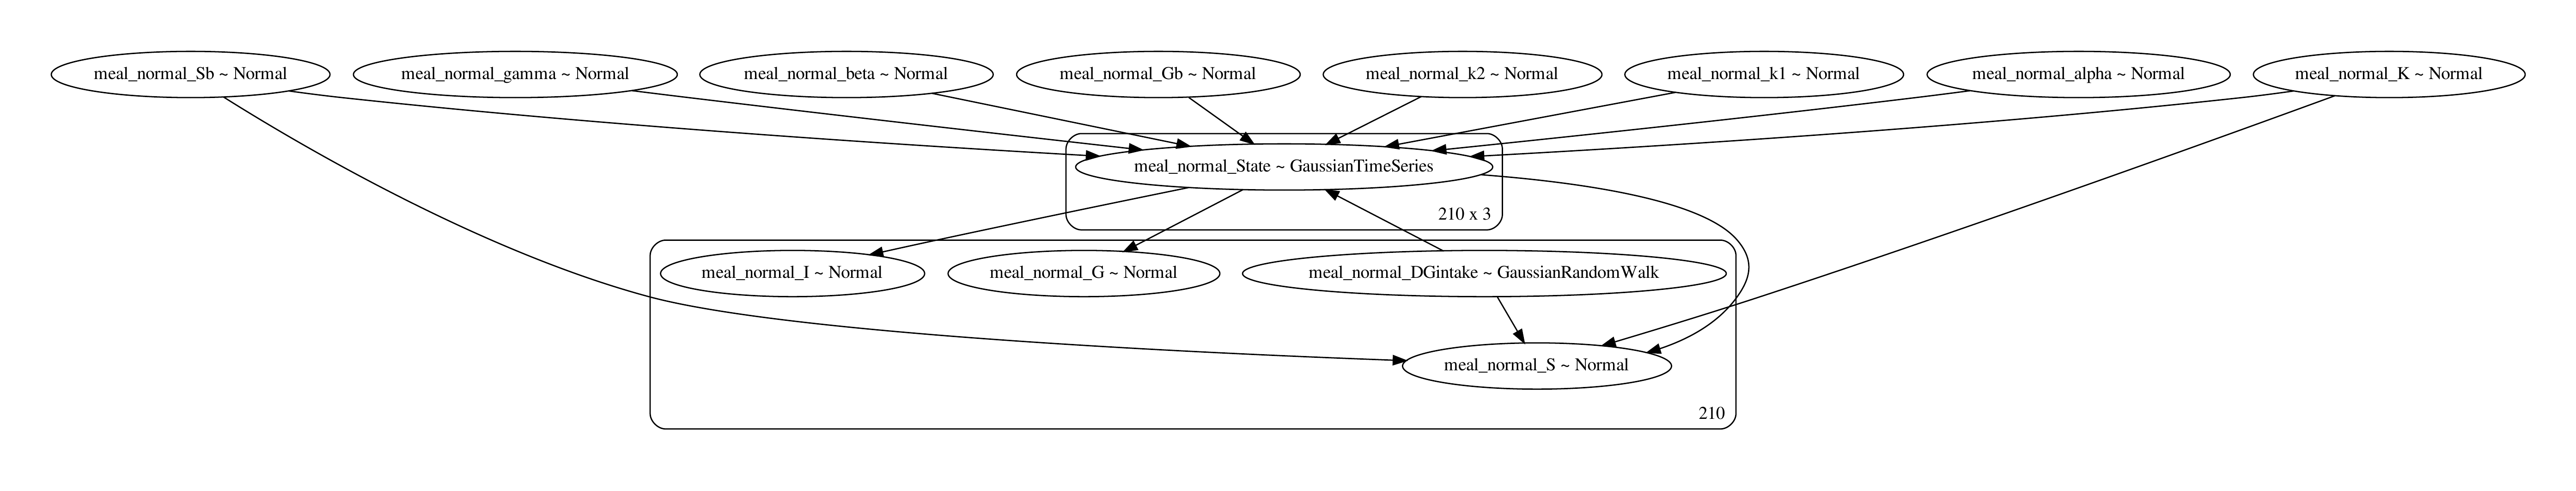


SPT Model


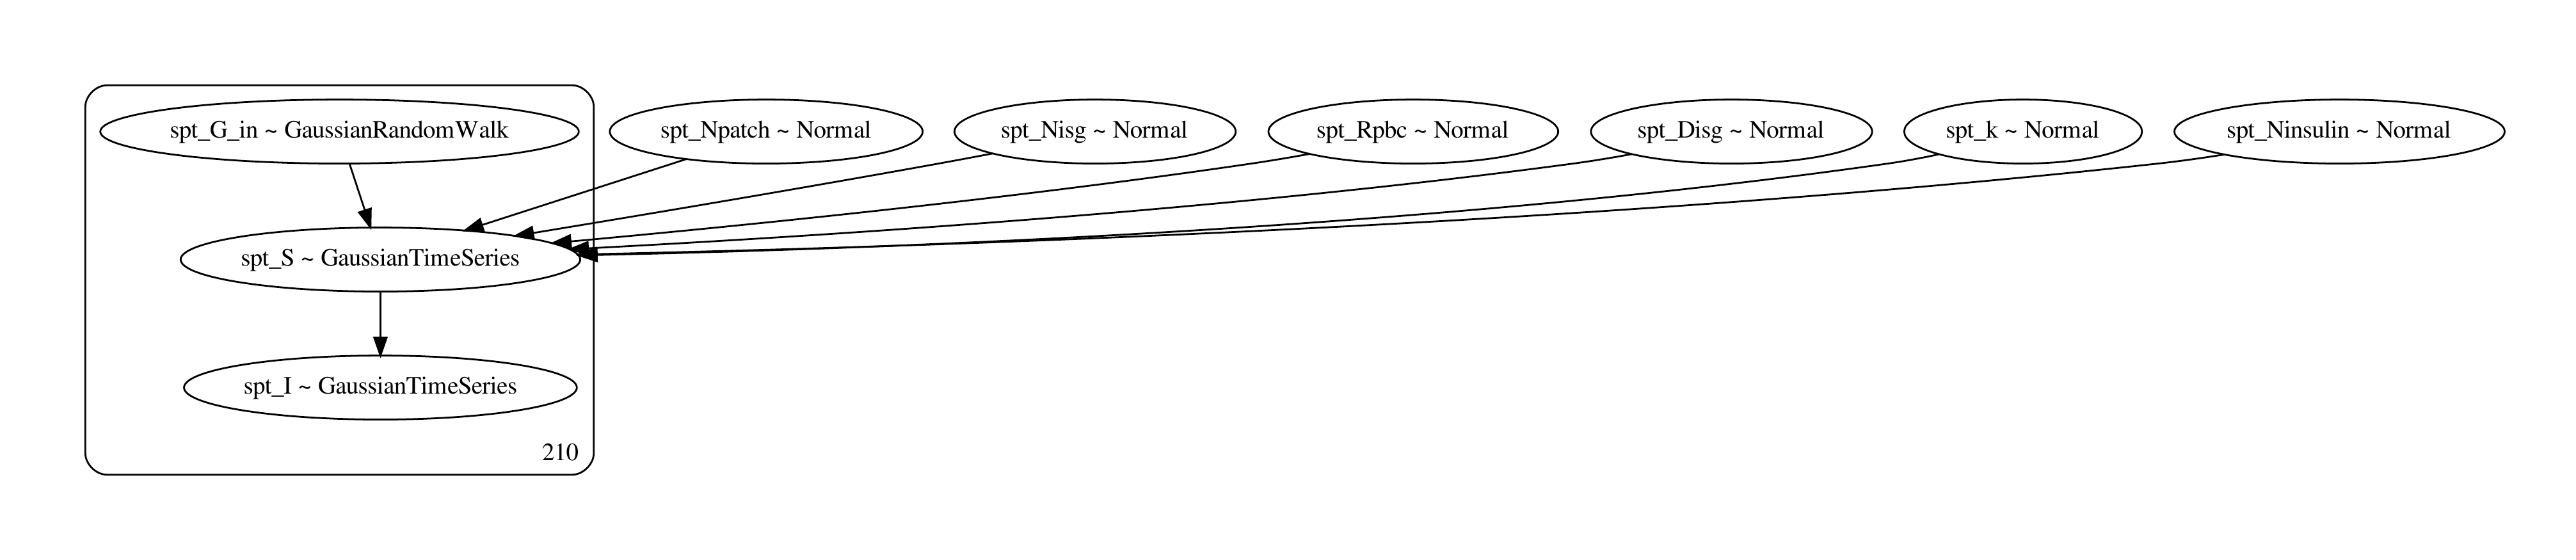

In [13]:
from mm.models import MealModel, SPTModel

meal_1 = MealModel(name="meal_normal", inputs={}, evidence={}, start={}, t=210, hpfn="./tutorial_datasets/default_params.json")
spt_1 = SPTModel(name="spt", inputs={}, evidence={}, start={}, t=210, hpfn="./tutorial_datasets/default_params.json")

print("\nMeal Model")
tu.visualize_model(meal_1, h=1000, w=800)

print("\nSPT Model")
tu.visualize_model(spt_1, h=1000, w=800)

## A. The meal model (postprandial response model)
The meal model is basically a well-known pharamcokinetic model for glucose induced postprandial insulin secretion composed of ordinary differential equations (ODE)s. You can find further details in [this paper](https://ieeexplore.ieee.org/document/4303268). We modified parts of the model so that you can think about it as a simulator that takes as input a concentration profile of ingested glucose (Gintake) and its derivative (DGintake) and produces the reponse concentrations of plasma glucose (G), plasma insulin (I) and insulin secretion rate (S), spatially averaged over the whole pancreas, on the timescale of minutes. Two versions of the model parameters are available in the literature: for "normal" (i.e., healthy subjects) and "t2d" (type-2 diabetic patients). 

## B. The spt (*s*patio-*t*emporal) model (vesicle exocytosis model)
The spt model is a toy demonstration of a (Brownian dynamics) particle simulator model of the intracellular insulin secretion. The full simulator is itself a simplified representation of glucose-insulin dynamics in the beta-cell, where insulin granules are treated as patchy particles that respond to collisions from diffusing glucose molecules, as well as harmonic forces from the cell-wall which serve the role of coarse-grained actin filament interactions. Due to both active (harmonic actin filament, collidin glucose molecule) and passive (self-diffusing) transport mechanisms, insulin granules migrate to the cell membrane where they can get secreted. The animation below tracks a single insulin granule (red) on its journey from the central nucleus to the cell membrane as it collides against glucose molecules (small beads) and other insulin vesicles (larger blue beads).

![SPTModel](./tutorial_figs/spt.gif "spt model")


The spt model in this tutorial is a *further simplification* of the full simulator in terms of lengths and time-scales, in that we assume that the intra-cellular glucose and insulin concentrations as well as insulin secretion rates are at comparable length and time-scales to the meal model. Relaxing this assumption will need more robust multiscale coupling strategies that mitigate the length and time-scaling issues between the characteristic time-scales of a systems-biology type model (minutes) and a mesoscopic particle simulation model (micro-seconds at best).

The spt model presented here is also slightly different from the one in the [manuscript](www.pnas.org) in the number of free parameters and their inter-dependencies.


Note: For the purposes of this tutorial, the length-scaling between the meal and spt model is acheived internally by treating each beta-cell as an independent secretory unit so that the total secretion from the pancreas is simply the number of cells times the individual secretion.

## C. The metamodel.
As explained before, the crucial protocol that allows one to couple two or more graphical models is the fact that putting an edge between certain nodes may create active trails which initiate information flow between them. In the figure below, the red edges form valid active trails between nodes in the two models.

<div><img src="./tutorial_figs/mm_meal_spt.png" width="800"></div>

Thus, the glucose concentration profile for the spt model is implemented as an input taken from the plasma glucose concentration profile for the meal model. Further the plasma insulin concentrations from both models are combined (simple arithmetic average, similar to the metamodel in section 2C) to produce a hybrid insulin profile (I_meta in the figure above) which carries information from both models.

At this point, it is instructive to remind ourselves that metamodeling is agnostic to the representation of the input submodels. The meal model consists only of chemical concentrations while the spt model (in principle, considering the full Brownian dynamics simulator) is described using particle coordinates. The statistical framework offered by PGMs allows the representational unification.

We will create a metamodel (named "meta") from the (pre-built) meal and spt models and use the two couplers mentioned above.

Quick note (only in the context of the Python code): we will pass an argument called ```hpfn``` to all model-builder functions. This stands for (h)yperprior (f)ile(n)ame. It is a json file containing all the <em>hyperpriors</em> (i.e. parameters used to define the prior probability distributions such as variances for Gaussian distributions, starting values for timeseries variables, etc). For this tutorial, a set of best-guess estimates of these quantities (meticulously curated by Liping Sun) have been kept in a file called ```tutorial_datasets/default_params.json```.

In [14]:
HP_FN = "./tutorial_datasets/default_params.json"

@jit
def MetaModel(name="meta", t=100,
              inputs={}, evidence={}, start={}, 
              hpfn=HP_FN, mealmodel_type="normal"):
    
    # call the meal model MBF
    mealmodel_name = "meal_%s" % mealmodel_type # normal or t2d
    meal = MealModel(name=mealmodel_name, t=t, inputs=inputs, evidence=evidence, start=start, hpfn=hpfn)
    
    # construct the first coupler (a modified inputs for the spt model)
    # intracellular glucose ~ 50% of extracellular glucose # assumption
    spt_inputs = {"G_in": 0.5*meal.G}
    
    # call the spt model MBF and pass in the first coupler
    spt = SPTModel(name="spt", t=t, inputs=spt_inputs, evidence=evidence, start=start, hpfn=hpfn)
    
    # combine (average) the plasma insulin (I) from meal and spt models
    I = pm.Normal("I", mu=(meal.I + spt.I)/2., sigma=0.01)

Once we have defined the MBF, we need to supply the ```inputs```, ```evidence``` and ```start``` arguments for this system, as elaborated while building the treatment model in section 2A. Data for this example is stored in files in the ```tutorial_datasets``` directory.

<strong>```inputs```</strong>
<br></br>
The input for this meta-model is the derivative of ingested glucose concentration ($\mathrm{DGintake} = \frac{d}{dt} \; \mathrm{Gintake}$) as a function of time (discretized for 420 mins with an interval $dt$=2 mins). Let us visualize this profile and load it into the ```inputs```variable.

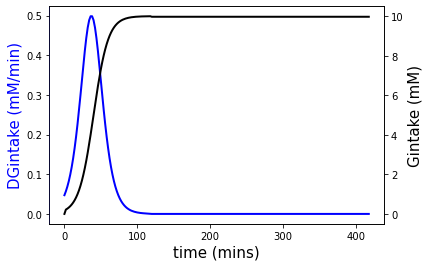

In [15]:
# timestep
dt = 2.0

# extract input data
input_data = np.loadtxt("./tutorial_datasets/Gintake.dat")
t_data = dt * input_data[:,0]
Gintake_data = input_data[:,2]
DGintake_data = input_data[:,1]

# load into dict
inputs = {"DGintake": DGintake_data}

# plot
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel("time (mins)", fontsize=15)
ax1.set_ylabel("DGintake (mM/min)", fontsize=15)
ax1.spines['left'].set_color('blue') ; ax1.yaxis.label.set_color('blue')
ax1.plot(t_data, DGintake_data, "b-", lw=2, label="DGintake")

ax2 = ax1.twinx()
ax2.set_ylabel("Gintake (mM)", fontsize=15)
ax2.plot(t_data, Gintake_data, "k-", lw=2);

<strong>```evidence```</strong>
<br></br>
The evidence used in this demonstration is a profile of plasma insulin concentrations for normal (healthy) and t2d (type-2 diabetic) cases, taken from literature. These are not exactly experimental data, rather outputs of more complex postpandrial glucose-insulin dynamics simulation models. Let us look at these profiles and then load them into the ```evidence``` variable.

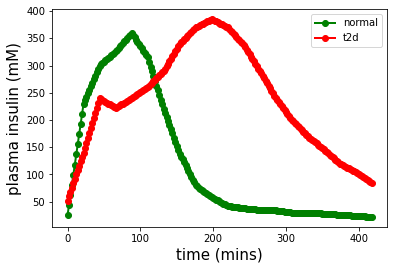

In [16]:
# extract data
normal_data = np.loadtxt("./tutorial_datasets/glucose_insulin_normal.dat")
t2d_data = np.loadtxt("./tutorial_datasets/glucose_insulin_t2d.dat")
I_normal_data = normal_data[:,2]
I_t2d_data = t2d_data[:,2]

# load into evidence dict (use full names of variable, i.e. meta-model name + "_" + variable name)
evidence_normal = {"meta_I": I_normal_data}
evidence_t2d =    {"meta_I": I_t2d_data}

# plot
plt.plot(t_data, I_normal_data, "go-", lw=2, label="normal")
plt.plot(t_data, I_t2d_data, "ro-", lw=2, label="t2d")
plt.xlabel("time (mins)", fontsize=15)
plt.ylabel("plasma insulin (mM)", fontsize=15)
plt.legend()
plt.show();

<strong>```start```</strong>
<br></br>
This metamodel has time-varying quantities that depend on their previous time points (plasma glucose, plasma insulin, insulin secretion), so a ```start``` argument containing values of such quantities at $t=0$ must be provided. These values are already stored in the hyper-parameter file (```tutorial_datasets/default.json```, loaded in the ```HP_FN``` variable).

In [17]:
start_normal = {"meal_normal_State":  set_start(rvname="State", modelname="meal_normal", hpfn=HP_FN),
                "spt_S"            :  set_start(rvname="S", modelname="spt", hpfn=HP_FN),
                "spt_I"            :  set_start(rvname="I", modelname="spt", hpfn=HP_FN)}

start_t2d = {"meal_t2d_State"      :  set_start(rvname="State", modelname="meal_t2d", hpfn=HP_FN),
             "spt_S"               :  set_start(rvname="S", modelname="spt", hpfn=HP_FN),
             "spt_I"               :  set_start(rvname="I", modelname="spt", hpfn=HP_FN)}

## D. Bayesian parameter inference from the metamodel
We will build two PGMs of the metamodel, once with normal parameters for the component meal model and another with t2d parameters.


Building meta-model from meal and spt models for normal data...

Building meta-model from meal and spt models for t2d data...

PGM of the normal case (double click on the PGM to zoom in)


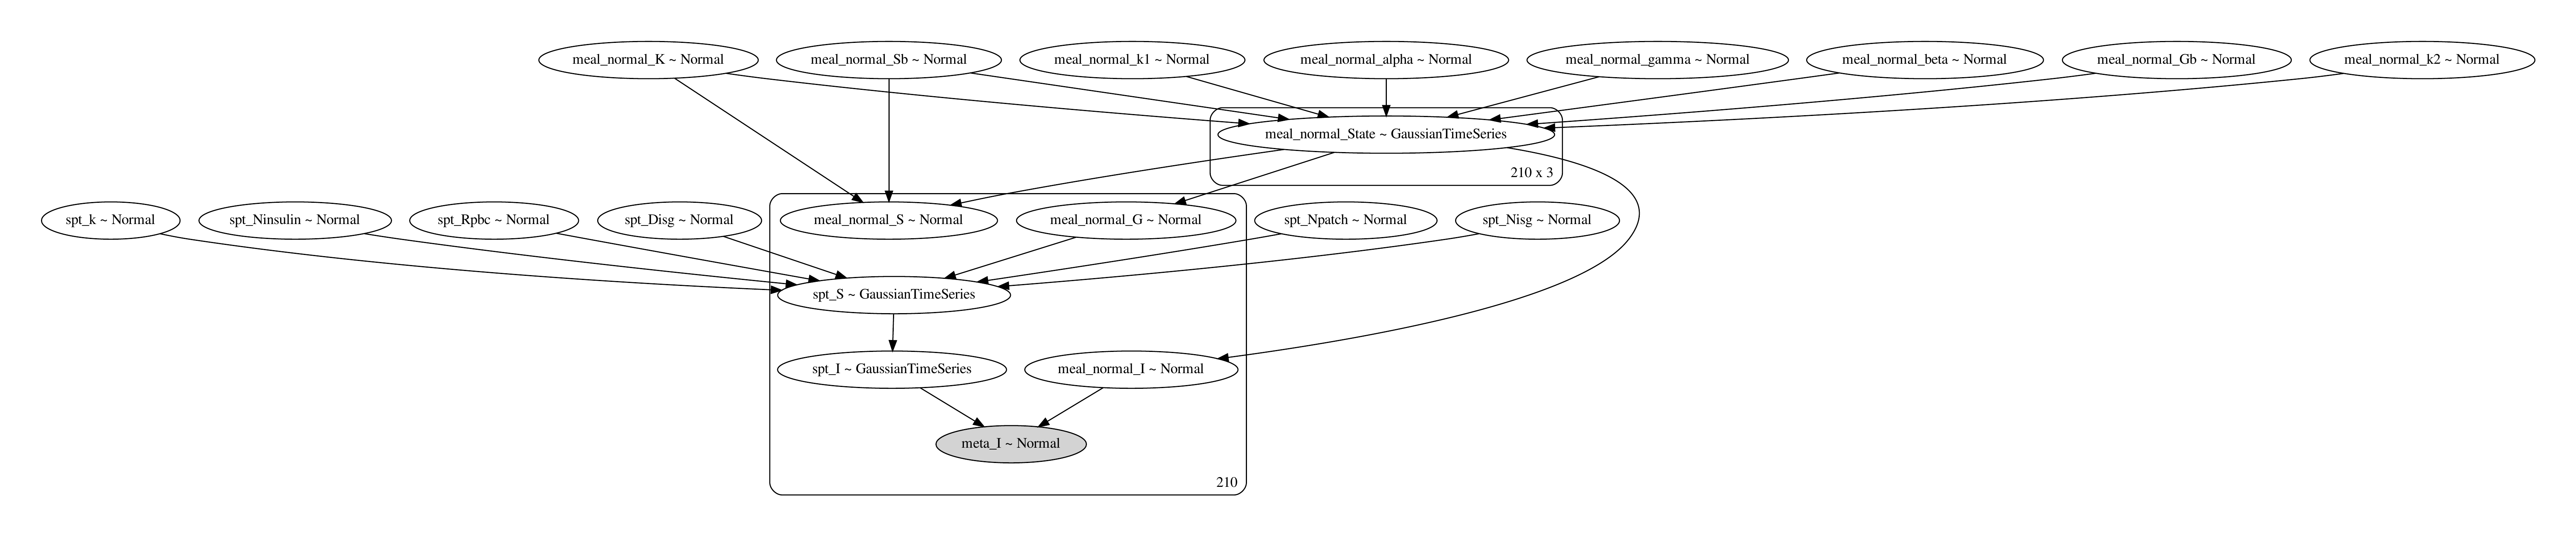

In [18]:
# number of time points
nt = len(DGintake_data)

# build the meta-models
print("\nBuilding meta-model from meal and spt models for normal data...")
mm_normal = MetaModel(name="meta", inputs=inputs, evidence=evidence_normal, start=start_normal, t=nt,
                       hpfn=HP_FN, mealmodel_type="normal")

print("\nBuilding meta-model from meal and spt models for t2d data...")
mm_t2d = MetaModel(name="meta", inputs=inputs, evidence=evidence_t2d, start=start_t2d, t=nt,
                  hpfn=HP_FN, mealmodel_type="t2d")
                         
# visualize the normal model (the t2d has the same topology, just different parameters)
print("\nPGM of the normal case (double click on the PGM to zoom in)")
tu.visualize_model(mm_normal, h=2500, w=2500)

Note how all nodes belong implicitly to the scope of their own models. Thus, nodes derived from the meal model all have the prefix ```meal_normal``` (or ```meal_t2d```) and nodes from the spt model are prefixed with ```spt```. Only the combined plasma insulin node (to which evidence is provided, hence shaded) is in the *meta* scope and hence prefixed with the name of the metamodel ```meta```. Also, just to avoid confusion, let us recall that notation such as ```meal_normal_S ~ Normal``` means that the variable ```S``` (insulin secretion rate) from the model ```meal_normal``` has a Normal i.e. Gaussian conditional probability distribution.

For the rest of this section, we will focus on three quantities: the actin network force constant $k$ from the spt model, the basal glucose level $G_b$ from the meal model and the insulin secretion rate $S$ from the meal model. As mentioned before (and for further details refer to the [supplementary information in the manuscript](www.pnas.org)), $k$ is an effective force coefficient that captures the collective role of the cytoskeletal actin filament network in vesicle transport.

We train both metamodels (normal and t2d) and collect posterior samples of $k$, $G_b$ and $S$. Training might take a while.

In [19]:
# collect prior samples from normal case
k_normal_pri_samples = tu.get_prior_samples(mm_normal, "spt_k", samples=ns)
Gb_normal_pri_samples = tu.get_prior_samples(mm_normal, "meal_normal_Gb", samples=ns)
S_normal_pri_samples = tu.get_prior_samples(mm_normal, "meal_normal_S", samples=ns)

# collect prior samples from t2d case
k_t2d_pri_samples = tu.get_prior_samples(mm_t2d, "spt_k", samples=ns)
Gb_t2d_pri_samples = tu.get_prior_samples(mm_t2d, "meal_t2d_Gb", samples=ns)
S_t2d_pri_samples = tu.get_prior_samples(mm_t2d, "meal_t2d_S", samples=ns)

# train normal case
print("\nTraining the meta-model on the normal data...")
_, trace_normal = tu.sample_posterior(mm_normal, tune=50000, samples=ns)
# collect prior samples samples from posterior
k_normal_post_samples = trace_normal["spt_k"]
Gb_normal_post_samples = trace_normal["meal_normal_Gb"]
S_normal_post_samples = trace_normal["meal_normal_S"]

# train t2d case
print("\nTraining the meta-model on the t2d data...")
_, trace_t2d = tu.sample_posterior(mm_t2d, tune=50000, samples=ns)
# collect samples from posterior
k_t2d_post_samples = trace_t2d["spt_k"]
Gb_t2d_post_samples = trace_t2d["meal_t2d_Gb"]
S_t2d_post_samples = trace_t2d["meal_t2d_S"]

# convert prior samples to distributions
k_normal_pri = tu.get_distribution(k_normal_pri_samples, vartype="static", smooth=True)
Gb_normal_pri = tu.get_distribution(Gb_normal_pri_samples, vartype="static", smooth=True)
S_normal_pri, S_normal_pri_err = tu.get_distribution(S_normal_pri_samples, vartype="dynamic")
k_t2d_pri = tu.get_distribution(k_t2d_pri_samples, vartype="static", smooth=True)
Gb_t2d_pri = tu.get_distribution(Gb_t2d_pri_samples, vartype="static", smooth=True)
S_t2d_pri, S_t2d_pri_err = tu.get_distribution(S_t2d_pri_samples, vartype="dynamic")

# convert posterior samples to distributions
k_normal_post = tu.get_distribution(k_normal_post_samples, vartype="static", smooth=True)
Gb_normal_post = tu.get_distribution(Gb_normal_post_samples, vartype="static", smooth=True)
S_normal_post, S_normal_post_err = tu.get_distribution(S_normal_post_samples, vartype="dynamic")
k_t2d_post = tu.get_distribution(k_t2d_post_samples, vartype="static", smooth=True)
Gb_t2d_post = tu.get_distribution(Gb_t2d_post_samples, vartype="static", smooth=True)
S_t2d_post, S_t2d_post_err = tu.get_distribution(S_t2d_post_samples, vartype="dynamic")


Training the meta-model on the normal data...


Average Loss = 2.1778e+10: 100%|██████████| 50000/50000 [00:45<00:00, 1089.17it/s]
Finished [100%]: Average Loss = 2.1778e+10



Training the meta-model on the t2d data...


Average Loss = 4.4756e+10: 100%|██████████| 50000/50000 [00:44<00:00, 1136.00it/s]
Finished [100%]: Average Loss = 4.4755e+10


Observe the estimates of the basal glucose level $G_b$.

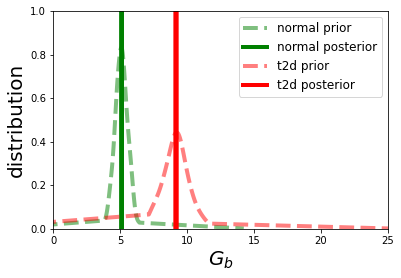

In [20]:
plt.plot(Gb_normal_pri[0], Gb_normal_pri[1], "g--", lw=4, alpha=0.5, label="normal prior")
plt.plot(Gb_normal_post[0], Gb_normal_post[1], "g-", lw=4, label="normal posterior")

plt.plot(Gb_t2d_pri[0], Gb_t2d_pri[1], "r--", lw=4, alpha=0.5, label="t2d prior")
plt.plot(Gb_t2d_post[0], Gb_t2d_post[1], "r-", lw=4, label="t2d posterior")

plt.xlim([0,25.0])
plt.ylim([0,1.0])
plt.xlabel(r"$G_b$", fontsize=20)
plt.ylabel("distribution", fontsize=20)
plt.legend(prop={"size":12});

The posterior distributions of $G_b$ have much less noise than their priors. Also basal glucose level for t2d data is higher than that for normal data (which is expected under diabetic conditions).

Next look at the actin network imposed force constant $k$.

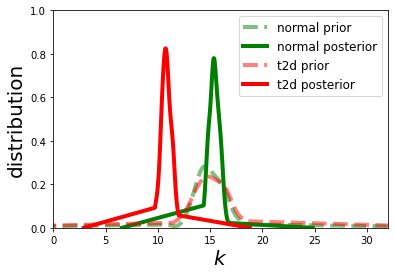

In [21]:
plt.plot(k_normal_pri[0], k_normal_pri[1], "g--", lw=4, alpha=0.5, label="normal prior")
plt.plot(k_normal_post[0], k_normal_post[1], "g-", lw=4, label="normal posterior")

plt.plot(k_t2d_pri[0], k_t2d_pri[1], "r--", lw=4, alpha=0.5, label="t2d prior")
plt.plot(k_t2d_post[0], k_t2d_post[1], "r-", lw=4, label="t2d posterior")

plt.xlim([0,32.0])
plt.ylim([0,1.0])
plt.xlabel(r"$k$", fontsize=20)
plt.ylabel(r"distribution", fontsize=20)
plt.legend(prop={"size":12});

Again, the posterior estimates of $k$ are much more confident than their prior distributions. More importantly, the priors for both normal and t2d case for $k$ are same while the posterior under t2d shifts to a lower average value. What does that mean?

1. Clearly the spt model *prior* to meta-modeling has no idea what t2d is (which is why their priors look the same), but proper information flow from the t2d paramters in the t2d meal model updates the posterior $k$ distribution. 


2. It is instructive to consider that $k$ represents microscopic biophysical data, which may be either unknown or difficult to measure experimentally. In this simplified example, we assumed that $k$ is known to some degree of uncertainty for healthy subjects and utilized information flow from plasma insulin data in the metamodel to estimate $k$ under diabetic conditions. Thus metamodeling can be a tool for determing unknown or experimentall difficult to measure model parameters (with quantifiable uncertainty).

3. Also, lower $k$ under t2d conditions potentially reflects slower granule trafficking to the cell membrane and thus lower overall secretion from the cell. However, this is not really an emergent property from the model, since no real biology is encoded in it. In principle, it is expected that more realistic metamodeling exercises can reveal new biology through the coupling between input models.

## Summary and Outlook

In this section, we found that:

1. Metamodeling can refine the estimates of model parameters in simplified models of cell biology.


2. Metamodeling can estimate parameters of models that are either unknown or experimentally hard to measure. Data used for parameterizing such input models need not be presented to that specific input model, rather it can be provided to any node on any (other) input model in the entire model.


3. The above features are possible due to rigorous statistical information flow protocols that are mathematically guaranteed if edges are drawn correctly between the underlying probabilistic graph representations of the different sub-models.


4. The couplers designed in this short example were intentionally chosen in a way that automatically guarantees information flow according to Bayes theorem. While these rules provide some heuristics, they don't provide absolute guidelines to design these couplers automatically. An important possible future direction would be the automated design of optimal couplers between input models.

5. It is equally important to design scale-bridging couplers so that continuum and particle based simulators can be effectively combined.

# Feedback 

Your feedback helps us to design more precise and effective ways to commuicate and disseminate information about metamodeling in the form of onboarding tools, such as this tutorial. If you found this tutorial helpful, please consider filling out this [survey](link)